In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.io import load_obj, load_objs_as_meshes

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

In [2]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.utilities.ipython_utils import display_vid

n_frames = 20
animation = AnimationArtifact.from_wandb_artifact_tag('flair:latest')
frame_indices = animation.frame_indices(n_frames)
frame_cams, frame_meshes = animation.load_frames(frame_indices)

depths = render_depth_map(frame_meshes, frame_cams)

display_vid(pil_frames_to_clip(depths))

In [3]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
from pathlib import Path
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
    GenerativeRenderingLogger,
)

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=0.8,
    attend_to_self_kv=True,
    mean_features_weight=0.0,
    chunk_size=5,
    num_keyframes=6,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)


prompt = "Stormtrooper"

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

noise_initializer = UVNoiseInitializer(noise_texture_res=40)
logger = GenerativeRenderingLogger(Path('data.h5'), enabled=False)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    generator=generator,
    logger=logger
)

100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


In [ ]:
display_vid(pil_frames_to_clip(video_frames), resolution=512)

: 

In [67]:
from text3d2video.util import ordered_sample_indices

depths = render_depth_map(frame_meshes, frame_cams)

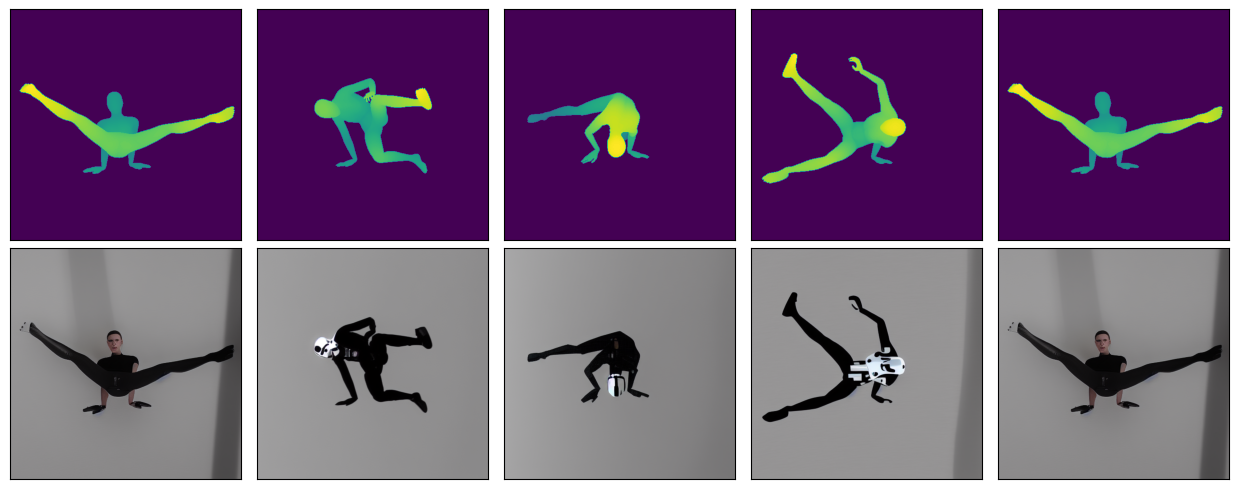

In [68]:
from text3d2video.ipython_utils import display_ims_grid

indices = ordered_sample_indices(depths, 5)

sampled_depth = [depths[i] for i in indices.tolist()]
sampled_frames = [video_frames[i] for i in indices.tolist()]

display_ims_grid([sampled_depth, sampled_frames])